# Задание к занятию «Деревья решений»

Описание задания:

1. Обязательная

    взять подготовленные раннее данные из задачи Titanic, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
    кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр grid в GridSearchCV )
    определить самые важные фичи
    вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

Результат: скрины нового сабмита на Kaggle и построенного дерева
 

2. Опциональная

    С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
    Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =)



## Обработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
X_full = pd.read_csv('train.csv', index_col='PassengerId')
X_val = pd.read_csv('test.csv', index_col='PassengerId')
X_full.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
y_full = X_full.pop('Survived')
X_full["isMale"] = X_full['Sex'].replace({"male": 1, "female":0})
X_val["isMale"] = X_val['Sex'].replace({"male": 1, "female":0})
X_full.drop(['Cabin', 'Ticket', 'Name','Sex'], axis=1, inplace=True)
X_val.drop(['Cabin', 'Ticket', 'Name','Sex'], axis=1, inplace=True)

In [4]:
X_full.shape, y_full.shape, X_val.shape

((891, 7), (891,), (418, 7))

In [5]:
X_full.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,isMale
PassengerId,,,,,,,
1,3,22.0,1,0,7.2500,S,1
2,1,38.0,1,0,71.2833,C,0
3,3,26.0,0,0,7.9250,S,0
4,1,35.0,1,0,53.1000,S,0
5,3,35.0,0,0,8.0500,S,1


In [6]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 7 columns):
Pclass      891 non-null int64
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
isMale      891 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 55.7+ KB


In [7]:
X_full['Embarked'] = X_full['Embarked'].fillna('nan')
X_val['Embarked'] = X_val['Embarked'].fillna('nan')

In [8]:
X_full = pd.get_dummies(X_full, columns=['Pclass', 'Embarked'])
X_val = pd.get_dummies(X_val, columns=['Pclass', 'Embarked'])
dumm_feat = X_full.columns & X_val.columns

X_full = X_full[dumm_feat]
X_val = X_val[dumm_feat]

In [9]:
X_full.shape, y_full.shape, X_val.shape

((891, 11), (891,), (418, 11))

In [10]:
X_full.head()

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,22.0,1,0,7.2500,1,0,0,1,0,0,1
2,38.0,1,0,71.2833,0,1,0,0,1,0,0
3,26.0,0,0,7.9250,0,0,0,1,0,0,1
4,35.0,1,0,53.1000,0,1,0,0,0,0,1
5,35.0,0,0,8.0500,1,0,0,1,0,0,1


## Дерево решений

In [11]:
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz   
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.30, random_state=42, stratify=y_full)

In [13]:
tree_pipe = Pipeline([
    ('prep', Imputer(strategy='mean')),
    ('clf', DecisionTreeClassifier(random_state=42))
])
tree_params = {
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [4, 5, 6, 7, 8, 9, 10],
    'clf__max_features': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
tree_grid = GridSearchCV(tree_pipe, param_grid=tree_params, cv=5, n_jobs=-1, scoring='accuracy')
tree_grid.fit(X_train, y_train)
print(tree_grid.best_estimator_.named_steps['clf'])
print('accuracy на cv: {}'.format(tree_grid.best_score_))
print('accuracy на train: {}'.format(tree_grid.score(X_train, y_train)))
print('accuracy на test: {}'.format(tree_grid.score(X_test, y_test)))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
accuracy на cv: 0.8330658105939005
accuracy на train: 0.8715890850722311
accuracy на test: 0.7873134328358209


## Важность признаков

Text(0,0.5,'Признак')

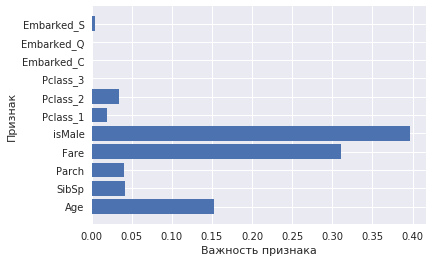

In [14]:
n_features = X_train.shape[1]

plt.barh(
    range(n_features),
    tree_grid.best_estimator_.named_steps['clf'].feature_importances_,
    align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel('Важность признака')
plt.ylabel('Признак')


## Визуализация дерева

In [15]:
export_graphviz(tree_grid.best_estimator_.named_steps['clf'],
                out_file='tree.dot',
                class_names=['NOT Survived', 'Survived'],
                feature_names=X_train.columns,
                impurity=False,
                filled=True
               )

In [16]:
#!conda install -c anaconda graphviz
#!pip install graphviz

In [17]:
X_train.head()

,Age,SibSp,Parch,Fare,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
749,19.0,1,0,53.1000,1,1,0,0,0,0,1
46,NaN,0,0,8.0500,1,0,0,1,0,0,1
29,NaN,0,0,7.8792,0,0,0,1,0,1,0
634,NaN,0,0,0.0000,1,1,0,0,0,0,1
404,28.0,1,0,15.8500,1,0,0,1,0,0,1


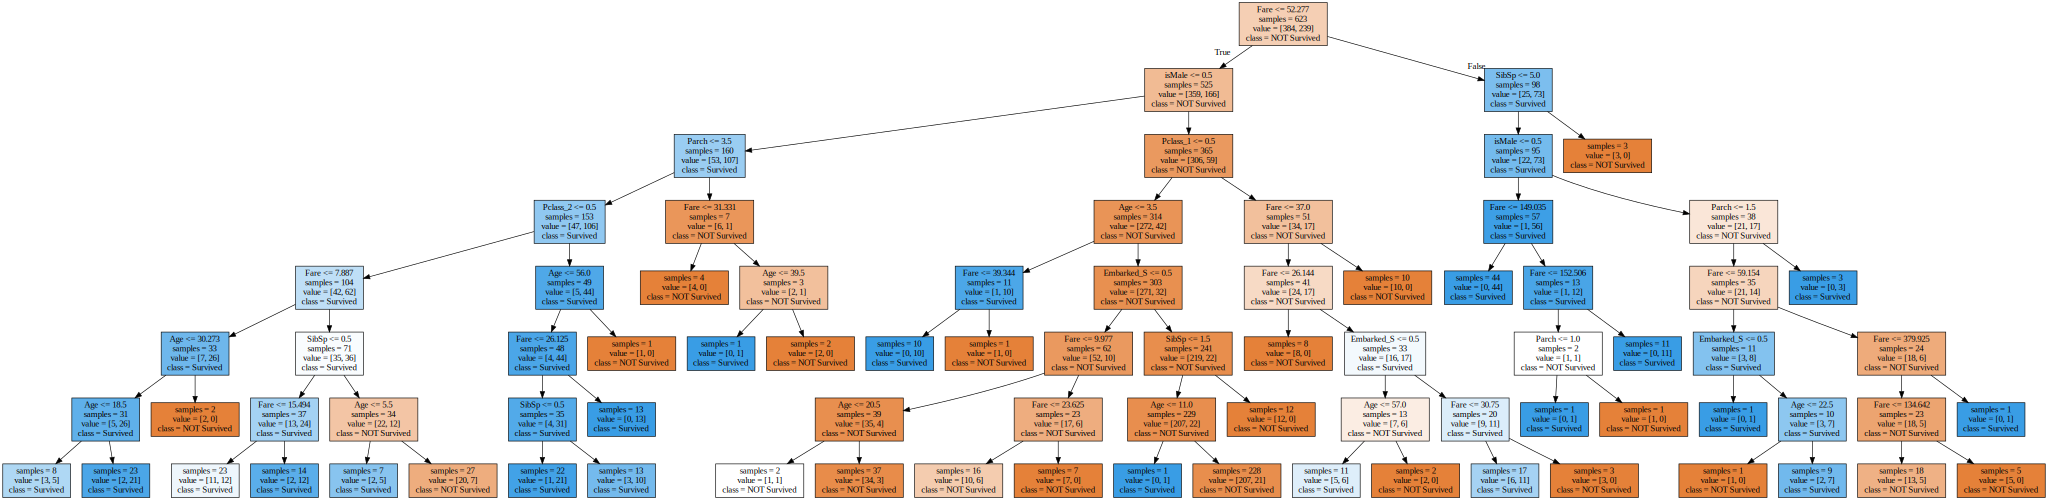

In [18]:
import graphviz
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## Ансамбли деревьев

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
rfc_pipe = Pipeline([
    ('prep', Imputer(strategy='mean')),
    ('clf', RandomForestClassifier(bootstrap=True, random_state=42))
])
rfc_params = {
    'clf__n_estimators': [5, 10, 15, 20],
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [2, 3, 4, 5, 6],
    'clf__max_features': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
rfc_grid = GridSearchCV(rfc_pipe, param_grid=rfc_params, cv=5, n_jobs=-1, scoring='accuracy')
rfc_grid.fit(X_train, y_train)
print(rfc_grid.best_estimator_.named_steps['clf'])
print('accuracy на cv: {}'.format(rfc_grid.best_score_))
print('accuracy на train: {}'.format(rfc_grid.score(X_train, y_train)))
print('accuracy на test: {}'.format(rfc_grid.score(X_test, y_test)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy на cv: 0.8426966292134831
accuracy на train: 0.841091492776886
accuracy на test: 0.8208955223880597


In [21]:
etc_pipe = Pipeline([
    ('prep', Imputer(strategy='mean')),
    ('clf', ExtraTreesClassifier(bootstrap=True, random_state=42))
])
etc_params = {
    'clf__n_estimators': [5, 10, 15, 20],
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': [2, 3, 4, 5, 6],
    'clf__max_features': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
etc_grid = GridSearchCV(etc_pipe, param_grid=etc_params, cv=5, n_jobs=-1, scoring='accuracy')
etc_grid.fit(X_train, y_train)
print(etc_grid.best_estimator_.named_steps['clf'])
print('accuracy на cv: {}'.format(etc_grid.best_score_))
print('accuracy на train: {}'.format(etc_grid.score(X_train, y_train)))
print('accuracy на test: {}'.format(etc_grid.score(X_test, y_test)))

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy',
           max_depth=6, max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
accuracy на cv: 0.8378812199036918
accuracy на train: 0.8523274478330658
accuracy на test: 0.8171641791044776


In [22]:
gbc_pipe = Pipeline([
    ('prep', Imputer(strategy='mean')),
    ('clf', GradientBoostingClassifier(random_state=42))
])
gbc_params = {
    'clf__learning_rate': [0.01, 0.1, 1],
    'clf__n_estimators': [100],
    'clf__max_depth': [1, 2, 3, 4],
    'clf__max_features': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
gbc_grid = GridSearchCV(gbc_pipe, param_grid=gbc_params, cv=5, n_jobs=-1, scoring='accuracy')
gbc_grid.fit(X_train, y_train)
print(gbc_grid.best_estimator_.named_steps['clf'])
print('accuracy на cv: {}'.format(gbc_grid.best_score_))
print('accuracy на train: {}'.format(gbc_grid.score(X_train, y_train)))
print('accuracy на test: {}'.format(gbc_grid.score(X_test, y_test)))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
accuracy на cv: 0.8394863563402889
accuracy на train: 0.8475120385232745
accuracy на test: 0.8097014925373134


## ROC AUC

In [23]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

DecisionTree:
ROC AUC: 0.8412
RandomForest:
ROC AUC: 0.8596
ExtraTrees:
ROC AUC: 0.8674
GradientBoosting:
ROC AUC: 0.8658


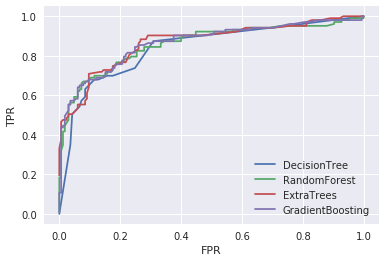

In [24]:

y_pred_tree = tree_grid.predict_proba(X_test)[:, 1]
y_pred_rfc = rfc_grid.predict_proba(X_test)[:, 1]
y_pred_etc = etc_grid.predict_proba(X_test)[:, 1]
y_pred_gbc = gbc_grid.predict_proba(X_test)[:, 1]

print('DecisionTree:')
calc_auc(y_test, y_pred_tree, 'DecisionTree')
print('RandomForest:')
calc_auc(y_test, y_pred_rfc, 'RandomForest')
print('ExtraTrees:')
calc_auc(y_test, y_pred_etc, 'ExtraTrees')
print('GradientBoosting:')
calc_auc(y_test, y_pred_gbc, 'GradientBoosting')
plt.legend();

## Финальное предсказание

In [25]:
predictions_tree = tree_grid.best_estimator_.fit(X_full,y_full).predict(X_val)
predictions_rfc = rfc_grid.best_estimator_.fit(X_full,y_full).predict(X_val)
predictions_etc = etc_grid.best_estimator_.fit(X_full,y_full).predict(X_val)
predictions_gbc = gbc_grid.best_estimator_.fit(X_full,y_full).predict(X_val)

In [32]:
submussion_tree = 'PassengerId,Survived\n'
submussion_tree += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(X_val.index, predictions_tree)])
with open('submission_tree.txt', 'w') as file:
    file.write(submussion_tree)

In [33]:
submussion_rfc = 'PassengerId,Survived\n'
submussion_rfc += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(X_val.index, predictions_rfc)])
with open('submission_rfc.txt', 'w') as file:
    file.write(submussion_rfc)

In [34]:
submussion_etc = 'PassengerId,Survived\n'
submussion_etc += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(X_val.index, predictions_etc)])
with open('submission_etc.txt', 'w') as file:
    file.write(submussion_etc)

In [35]:
submussion_gbc = 'PassengerId,Survived\n'
submussion_gbc += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(X_val.index, predictions_gbc)])
with open('submission_gbc.txt', 'w') as file:
    file.write(submussion_gbc)